In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [5]:
!pip freeze > requirements.txt

# SETUP

In [6]:
CONFIG_DIR = '../app/'

In [7]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [8]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-24'

In [9]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664301442,43379,32437,cancel,0xf22486a7aac772d3a22b93d2593e71ce743be295,NaN,NaN,sneakers,common,ranger,...,504.0,8544.0,30282,8517,280,3394,6533,11838,93.0,1.436214
1,1664301385,43181,40692,cancel,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,NaN,NaN,sneakers,rare,ranger,...,503.0,8544.0,30282,8517,280,3397,6533,11838,93.0,1.446281
2,1664301385,43522,17317,sell,0x9fc140825605781abc210a1cb98ee68f8a27b80f,NaN,0.64,sneakers,common,hiker,...,503.0,8544.0,NaN,NaN,NaN,NaN,NaN,NaN,93.0,1.446281
3,1664301349,43193,60412,cancel,0xda92f9ce0f36f8a404e199b1282f7514800f59c8,NaN,NaN,sneakers,rare,coacher,...,504.0,8544.0,30282,4584,280,3398,6533,11838,93.0,1.450413
4,1664301334,43182,43027,cancel,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,NaN,NaN,sneakers,rare,ranger,...,504.0,8544.0,30282,8517,280,3398,6534,11838,93.0,1.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59160,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
59161,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
59162,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
59163,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59165 entries, 0 to 59164
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  41223 non-null  float64
 1   time_ownership             41223 non-null  float64
 2   wallet_box_mint            41223 non-null  float64
 3   wallet_sneaker_mint        41223 non-null  float64
 4   time_level_up              38008 non-null  float64
 5   time_level_up_for_mint     41239 non-null  float64
 6   base_mint_price_amt        41239 non-null  float64
 7   base_mint_price_azy        41239 non-null  float64
 8   base_mint_price_bnb        31216 non-null  float64
dtypes: float64(9)
memory usage: 4.1 MB


In [13]:
data.genesis

0        False
1        False
2         True
3        False
4        False
         ...  
59160     True
59161    False
59162    False
59163    False
59164     True
Name: genesis, Length: 59165, dtype: bool

In [14]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
6,1664301313,42986,52050,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,hiker,...,504.0,8545.0,30282,9257,280,3399,6534,11838,93.0,1.454545
8,1664301286,43480,46214,buy,0x1f3371752a645ef4d0ddfbe85c26c939b864825f,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,505.0,8545.0,30282,7924,280,3399,6534,11838,93.0,1.462810
10,1664301241,43482,37697,buy,0x5dd24de8af05b69bf75eaa8ade81715d8c4bcb40,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,ranger,...,506.0,8544.0,30282,8517,280,3399,6535,11838,93.0,1.471074
11,1664301205,42762,37087,buy,0xd4a6fb395f3e424285000ed57b13a413529715a2,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,506.0,8544.0,30282,7924,280,3400,6536,11838,93.0,1.475207
22,1664301049,43077,36893,buy,0x8afab49dfb0ca03ab127f5ea58e3d150087c1903,0x626d11d87adda0bec5e7147e19b4d755ba13551a,0.58,sneakers,common,ranger,...,510.0,8542.0,30280,8517,279,3400,6535,11836,92.0,1.493827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59102,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
59125,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
59139,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
59144,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [15]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

cancel_count_24H more then expected. get: 1348 | expected: 1000


In [16]:
data['mint'].isna().sum()

0

In [17]:
data[data['level'] == 9]['mint'].value_counts()

2.0    161
0.0     62
3.0     43
1.0     20
4.0      1
Name: mint, dtype: int64

In [18]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
131,1664297347,43297,31320,buy,0x439f3987d4f74c6647e110bfbea9a358564b1cee,0xbcebb32db3db2b30791c8dceb2f8d76bd005dd49,1.10,sneakers,common,hiker,...,531.0,8537.0,30270,9252,312,3456,6543,11833,93.0,1.519685
425,1664290684,43217,47028,buy,0x9bcff28bb4cd1e9d2bf0db6e07ba56251d2d8f0d,0x64eeacf1365068c8b4c7b3ddae39b2c2005fcd01,1.29,sneakers,common,hiker,...,513.0,8535.0,30254,9246,364,3582,6567,11827,90.0,1.625532
537,1664289113,43238,31325,buy,0xf191581b3e5c7e2bd4fbfb838604b28b38264024,0x5f2e8a7571dabf9325fa5cc27caf9a995832f5ed,2.38,sneakers,uncommon,hiker,...,519.0,8541.0,30248,9246,370,3619,6565,11826,91.0,1.557851
545,1664288963,43157,27775,buy,0xe44f63b2d9b7392d4dd41d528724780ee9db74c6,0xb22ab7d5bf9484638d30f5ebe7bfba04a6953aa2,1.20,sneakers,common,ranger,...,522.0,8540.0,30247,8502,370,3621,6564,11825,91.0,1.553279
1052,1664279480,42963,47069,buy,0xa21901993ac74f3d7db6eea3e1b5fdc94879da7e,0x7c270d82b64978efc65670572e979739947d9252,3.20,sneakers,uncommon,hiker,...,584.0,8526.0,30202,9232,390,3765,6569,11814,94.0,1.365854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54537,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,17470,4485,311,2399,6350,17470,NaN,NaN
55313,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,17224,4417,284,2324,6191,17224,NaN,NaN
56466,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,16921,3733,531,5201,6000,16921,NaN,NaN
56827,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,16746,3720,452,5118,5868,16746,NaN,NaN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10488 entries, 6 to 59158
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        10488 non-null  int64  
 1   mrk_id                                           10488 non-null  int64  
 2   token_id                                         10488 non-null  int64  
 3   event                                            10488 non-null  object 
 4   wallet_from                                      10476 non-null  object 
 5   wallet_to                                        10488 non-null  object 
 6   price                                            10488 non-null  float64
 7   item_type                                        10488 non-null  object 
 8   rarity                                           10488 non-null  object 
 9   sneaker_type                

In [20]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10488 entries, 6 to 59158
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  10488 non-null  float64
 1   time_ownership             10488 non-null  float64
 2   wallet_box_mint            10488 non-null  float64
 3   wallet_sneaker_mint        10488 non-null  float64
 4   time_level_up              10488 non-null  float64
 5   time_level_up_for_mint     10488 non-null  float64
 6   base_mint_price_amt        10488 non-null  float64
 7   base_mint_price_azy        10488 non-null  float64
 8   base_mint_price_bnb        8098 non-null   float64
dtypes: float64(9)
memory usage: 819.4 KB


In [21]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
6,1.657823e+09,24083.0,19.0,17.0,900.0,1800.0,300.0,200.0,0.532045
8,1.663518e+09,3996.0,0.0,0.0,1680.0,1800.0,300.0,200.0,0.532045
10,1.657800e+09,3894.0,14.0,20.0,900.0,1800.0,300.0,200.0,0.532045
11,1.659543e+09,32227.0,7.0,1.0,900.0,1800.0,300.0,200.0,0.532045
22,1.659442e+09,20528.0,7.0,11.0,900.0,1800.0,300.0,200.0,0.531905
...,...,...,...,...,...,...,...,...,...
59102,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
59125,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
59139,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
59144,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [22]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [23]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [24]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [25]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10488 entries, 6 to 59158
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        10488 non-null  int64  
 1   mrk_id                                           10488 non-null  int64  
 2   token_id                                         10488 non-null  int64  
 3   event                                            10488 non-null  object 
 4   wallet_from                                      10476 non-null  object 
 5   wallet_to                                        10488 non-null  object 
 6   price                                            10488 non-null  float64
 7   item_type                                        10488 non-null  object 
 8   rarity                                           10488 non-null  object 
 9   sneaker_type                

In [27]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
6,1664301313,42986,52050,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,hiker,...,504.0,8545.0,30282,9257,280,3399,6534,11838,93.0,1.454545
8,1664301286,43480,46214,buy,0x1f3371752a645ef4d0ddfbe85c26c939b864825f,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,505.0,8545.0,30282,7924,280,3399,6534,11838,93.0,1.462810
10,1664301241,43482,37697,buy,0x5dd24de8af05b69bf75eaa8ade81715d8c4bcb40,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,ranger,...,506.0,8544.0,30282,8517,280,3399,6535,11838,93.0,1.471074
11,1664301205,42762,37087,buy,0xd4a6fb395f3e424285000ed57b13a413529715a2,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,506.0,8544.0,30282,7924,280,3400,6536,11838,93.0,1.475207
22,1664301049,43077,36893,buy,0x8afab49dfb0ca03ab127f5ea58e3d150087c1903,0x626d11d87adda0bec5e7147e19b4d755ba13551a,0.58,sneakers,common,ranger,...,510.0,8542.0,30280,8517,279,3400,6535,11836,92.0,1.493827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59102,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
59125,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
59139,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
59144,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [28]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [29]:
len(data)

10488

In [30]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

10279

уберем выбросы

In [31]:
data = data[(data['price'] > 0.4)]
len(data)

10275

In [32]:
data = data[~((data['genesis']) & (data['price'] < 0.5))].copy()
len(data)

10273

In [33]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [34]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [35]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [36]:
#data['bin_level'].value_counts()

In [37]:
#data['bin_mint'].value_counts()

In [38]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [39]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [40]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [41]:
data['token_sell_activity_6H'].max()

11.0

In [42]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [43]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [44]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

6318

In [45]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [46]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
43177,277.756081,0.113478,0.552838,0.678822
43176,277.756081,0.113478,0.552838,0.678822
43170,278.034632,0.112454,0.552219,0.676738
43168,278.034632,0.112460,0.552195,0.676716
43156,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
10437,277.992552,0.066086,0.540967,0.631338
10430,277.731211,0.066002,0.544333,0.635507
10426,277.858016,0.065821,0.544053,0.634785
10422,278.082246,0.065731,0.545936,0.636240


In [47]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [48]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
43177,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
43176,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
43170,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
43168,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
43156,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10437,277.992552,0.066086,0.540967,1.657800e+09,213.0,15.0,13.0,900.0,1800.0,300.0,200.0,0.631338,2022-09-23 23:14:56
10430,277.731211,0.066002,0.544333,1.657800e+09,538157.0,16.0,19.0,900.0,1800.0,300.0,200.0,0.635507,2022-09-23 23:26:29
10426,277.858016,0.065821,0.544053,1.657800e+09,539264.0,9.0,6.0,900.0,1800.0,300.0,200.0,0.634785,2022-09-23 23:35:35
10422,278.082246,0.065731,0.545936,1.657800e+09,3352225.0,16.0,18.0,900.0,1800.0,300.0,200.0,0.636240,2022-09-23 23:49:11


In [49]:
train_data.base_mint_price_azy.value_counts()

200.0     5900
800.0      413
3200.0       5
Name: base_mint_price_azy, dtype: int64

In [50]:
[
'rarity',
'sneaker_type',
'genesis',
'level',
'base_performance',
'base_fortune',
'base_joy',
'base_durability',
'performance',
'fortune',
'joy',
'durability',
'mint',
'buy_count_24H',
'sell_count_24H',
'cancel_count_24H',
'min_price_all_24H',
'sells_activity_24H',
'min_price_by_rarity_genesis_type_level_mint_48H',
'min_price_by_rarity_genesis_type_24H',
'time_level_up', 
'base_mint_price_bnb',
'price_bnb',
'price',
]

['rarity',
 'sneaker_type',
 'genesis',
 'level',
 'base_performance',
 'base_fortune',
 'base_joy',
 'base_durability',
 'performance',
 'fortune',
 'joy',
 'durability',
 'mint',
 'buy_count_24H',
 'sell_count_24H',
 'cancel_count_24H',
 'min_price_all_24H',
 'sells_activity_24H',
 'min_price_by_rarity_genesis_type_level_mint_48H',
 'min_price_by_rarity_genesis_type_24H',
 'time_level_up',
 'base_mint_price_bnb',
 'price_bnb',
 'price']

In [51]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [52]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [53]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.05s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.02s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:06,  2.02s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:08,  2.01s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:10,  1.99s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:12,  1.99s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:14,  2.00s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:16,  1.99s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:18,  1.99s/it]iteritems is deprec

In [54]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.909,0.0825
MAE,0.088,0.0144
MSE,0.134,0.1814
RMSE,0.319,0.1835
MAPE,0.057,0.0028


In [55]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.909,0.0825
MAE,0.088,0.0144
MSE,0.134,0.1814
RMSE,0.319,0.1835
MAPE,0.057,0.0028


In [56]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.892, 'MAE': 0.088, 'MSE': 0.134, 'RMSE': 0.366, 'MAPE': 0.057}

In [57]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


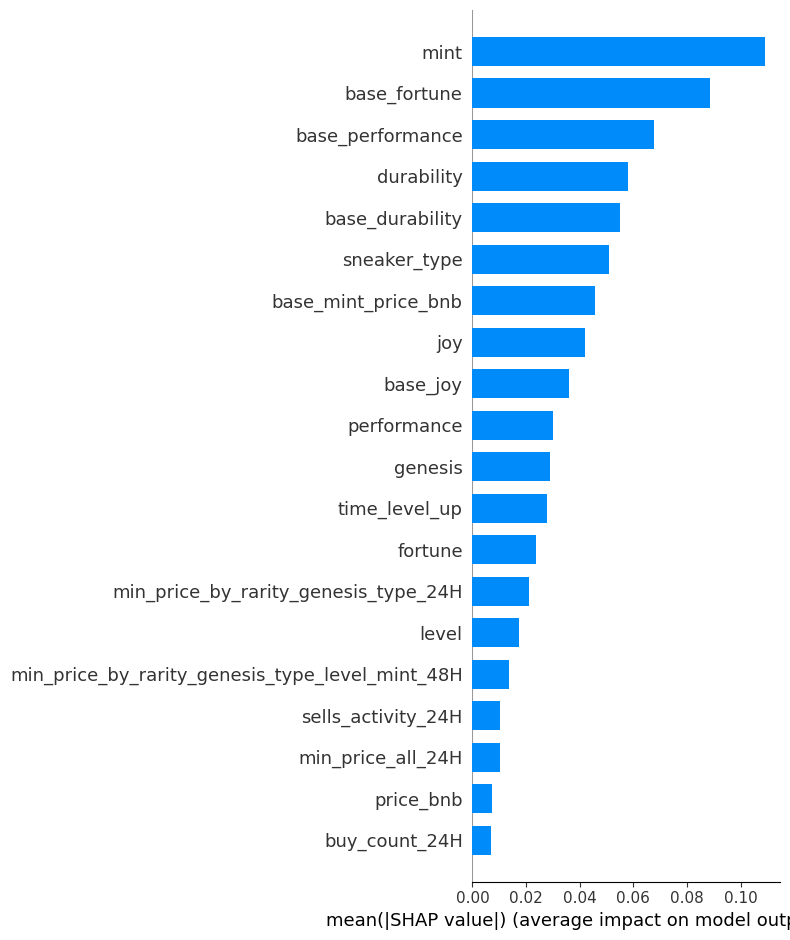

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [59]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.054786
0:	learn: 1.0661945	total: 3.35ms	remaining: 3.35s
1:	learn: 1.0238026	total: 7.02ms	remaining: 3.5s
2:	learn: 0.9817629	total: 9.63ms	remaining: 3.2s
3:	learn: 0.9427914	total: 12ms	remaining: 3s
4:	learn: 0.9089950	total: 14.3ms	remaining: 2.84s
5:	learn: 0.8739849	total: 16.4ms	remaining: 2.72s
6:	learn: 0.8404429	total: 18.6ms	remaining: 2.63s
7:	learn: 0.8093113	total: 20.5ms	remaining: 2.54s
8:	learn: 0.7798255	total: 22.5ms	remaining: 2.48s
9:	learn: 0.7533437	total: 24.6ms	remaining: 2.43s
10:	learn: 0.7279178	total: 26.5ms	remaining: 2.38s
11:	learn: 0.7029912	total: 28.6ms	remaining: 2.35s
12:	learn: 0.6797159	total: 30.6ms	remaining: 2.32s
13:	learn: 0.6585525	total: 32.8ms	remaining: 2.31s
14:	learn: 0.6383243	total: 34.7ms	remaining: 2.28s
15:	learn: 0.6170875	total: 36.5ms	remaining: 2.24s
16:	learn: 0.5996392	total: 38.5ms	remaining: 2.22s
17:	learn: 0.5797905	total: 40.4ms	remaining: 2.2s
18:	learn: 0.5619822	total: 42.4ms	remaining: 2.19s


In [60]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.628, 'MAE': 0.206, 'MSE': 0.22, 'RMSE': 0.469, 'MAPE': 0.222}

In [61]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.628, 'MAE': 0.206, 'MSE': 0.22, 'RMSE': 0.469, 'MAPE': 0.222}

In [62]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.628, 'MAE': 0.206, 'MSE': 0.22, 'RMSE': 0.469, 'MAPE': 0.222}

## Fit full Model

In [63]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.056407
0:	learn: 1.0226168	total: 3.04ms	remaining: 3.04s
1:	learn: 0.9813910	total: 6.07ms	remaining: 3.03s
2:	learn: 0.9427009	total: 8.81ms	remaining: 2.93s
3:	learn: 0.9055722	total: 11ms	remaining: 2.75s
4:	learn: 0.8705789	total: 13.3ms	remaining: 2.65s
5:	learn: 0.8381008	total: 15.6ms	remaining: 2.58s
6:	learn: 0.8087853	total: 17.7ms	remaining: 2.52s
7:	learn: 0.7797650	total: 19.9ms	remaining: 2.46s
8:	learn: 0.7519905	total: 21.9ms	remaining: 2.41s
9:	learn: 0.7244666	total: 24.1ms	remaining: 2.39s
10:	learn: 0.7002960	total: 26.2ms	remaining: 2.35s
11:	learn: 0.6752784	total: 28.3ms	remaining: 2.33s
12:	learn: 0.6535625	total: 30.5ms	remaining: 2.32s
13:	learn: 0.6331441	total: 32.6ms	remaining: 2.3s
14:	learn: 0.6133344	total: 34.9ms	remaining: 2.29s
15:	learn: 0.5933534	total: 37.2ms	remaining: 2.29s
16:	learn: 0.5760957	total: 39.4ms	remaining: 2.28s
17:	learn: 0.5595621	total: 41.6ms	remaining: 2.27s
18:	learn: 0.5437981	total: 43.7ms	remaining: 2

### Test

In [64]:
i=1800

In [65]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                         sprinter
genesis                                                 False
level                                                     0.0
base_performance                                          8.9
base_fortune                                              8.0
base_joy                                                  7.4
base_durability                                           3.8
performance                                               8.9
fortune                                                   8.0
joy                                                       7.4
durability                                                3.8
mint                                                      0.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.830721
min_pric

In [66]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [67]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.832

In [68]:
data.iloc[i]['price']

0.83

iteritems is deprecated and will be removed in a future version. Use .items instead.


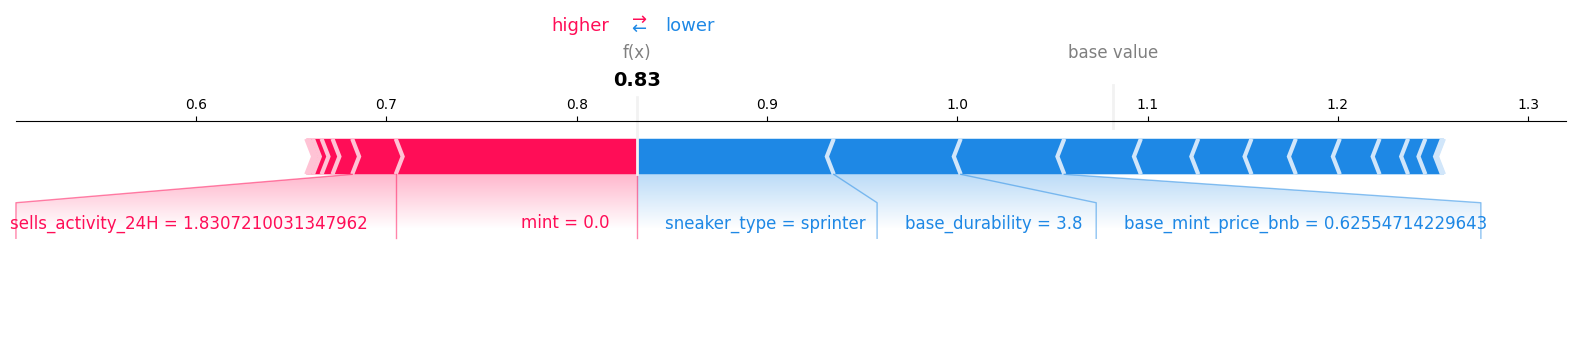

In [69]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [70]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [71]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [72]:
X.genesis.value_counts()

False    5541
True     2057
Name: genesis, dtype: int64

In [73]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5.0,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5.0,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5.0,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5.0,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10.0,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,common,ranger,False,5.0,1.2,8.7,8.0,5.6,16.7,13.2,12.0,8.6,2.0
7594,common,sprinter,False,5.0,9.4,8.4,2.1,1.0,23.9,12.4,3.1,6.5,2.0
7595,common,ranger,False,5.0,9.9,2.8,1.9,5.4,25.9,4.3,2.9,11.9,2.0
7596,common,sprinter,False,7.0,9.8,5.4,8.1,5.7,37.8,8.9,13.7,9.9,2.0


In [74]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.85s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.85s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:07,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:09,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:11,  1.85s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:12,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:14,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:16,  1.84s/it]iteritems is deprec

In [75]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.900,0.0883
MAE,0.105,0.0166
MSE,0.148,0.1951
RMSE,0.337,0.1869
MAPE,0.074,0.0035


In [76]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.900,0.0883
MAE,0.105,0.0166
MSE,0.148,0.1951
RMSE,0.337,0.1869
MAPE,0.074,0.0035


In [77]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.881, 'MAE': 0.105, 'MSE': 0.148, 'RMSE': 0.384, 'MAPE': 0.074}

In [78]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


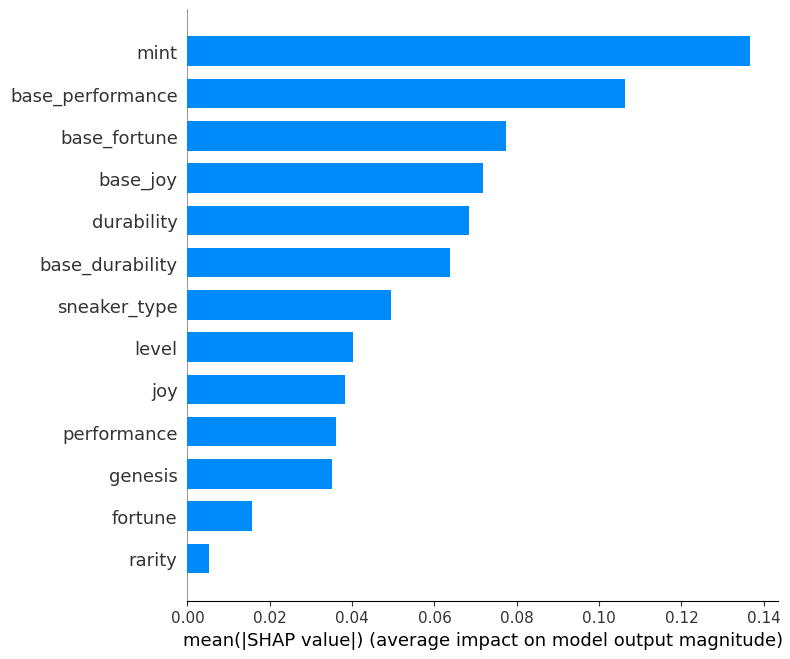

In [79]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [80]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [81]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.054786
0:	learn: 1.0675981	total: 2.92ms	remaining: 2.92s
1:	learn: 1.0240431	total: 5.64ms	remaining: 2.81s
2:	learn: 0.9822743	total: 8ms	remaining: 2.66s
3:	learn: 0.9441231	total: 9.99ms	remaining: 2.49s
4:	learn: 0.9082874	total: 11.8ms	remaining: 2.34s
5:	learn: 0.8725093	total: 13.5ms	remaining: 2.24s
6:	learn: 0.8402413	total: 15.4ms	remaining: 2.18s
7:	learn: 0.8097773	total: 17.1ms	remaining: 2.12s
8:	learn: 0.7808250	total: 19.1ms	remaining: 2.1s
9:	learn: 0.7535230	total: 21.1ms	remaining: 2.09s
10:	learn: 0.7273031	total: 23ms	remaining: 2.07s
11:	learn: 0.7031522	total: 24.9ms	remaining: 2.05s
12:	learn: 0.6797166	total: 26.8ms	remaining: 2.04s
13:	learn: 0.6558176	total: 28.6ms	remaining: 2.02s
14:	learn: 0.6328385	total: 30.6ms	remaining: 2.01s
15:	learn: 0.6135350	total: 32.5ms	remaining: 2s
16:	learn: 0.5936390	total: 34.3ms	remaining: 1.98s
17:	learn: 0.5781013	total: 36.2ms	remaining: 1.98s
18:	learn: 0.5603673	total: 38.2ms	remaining: 1.97s
1

{'R2': 0.65, 'MAE': 0.232, 'MSE': 0.206, 'RMSE': 0.454, 'MAPE': 0.262}

## Fit full Base model

In [82]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.056407
0:	learn: 1.0248063	total: 2.98ms	remaining: 2.98s
1:	learn: 0.9847195	total: 6.17ms	remaining: 3.08s
2:	learn: 0.9463416	total: 8.84ms	remaining: 2.94s
3:	learn: 0.9089296	total: 11ms	remaining: 2.75s
4:	learn: 0.8747689	total: 13.1ms	remaining: 2.61s
5:	learn: 0.8424886	total: 15.1ms	remaining: 2.5s
6:	learn: 0.8115612	total: 17.1ms	remaining: 2.42s
7:	learn: 0.7824366	total: 19.1ms	remaining: 2.36s
8:	learn: 0.7538239	total: 21.1ms	remaining: 2.32s
9:	learn: 0.7281917	total: 23.1ms	remaining: 2.29s
10:	learn: 0.7038327	total: 25.2ms	remaining: 2.26s
11:	learn: 0.6791650	total: 27.2ms	remaining: 2.24s
12:	learn: 0.6570874	total: 29.3ms	remaining: 2.22s
13:	learn: 0.6344287	total: 31.4ms	remaining: 2.21s
14:	learn: 0.6155731	total: 33.4ms	remaining: 2.19s
15:	learn: 0.5981774	total: 35.4ms	remaining: 2.17s
16:	learn: 0.5806039	total: 37.5ms	remaining: 2.17s
17:	learn: 0.5651873	total: 39.3ms	remaining: 2.15s
18:	learn: 0.5486650	total: 41.3ms	remaining: 2

### Test

In [83]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [84]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

1.94

iteritems is deprecated and will be removed in a future version. Use .items instead.


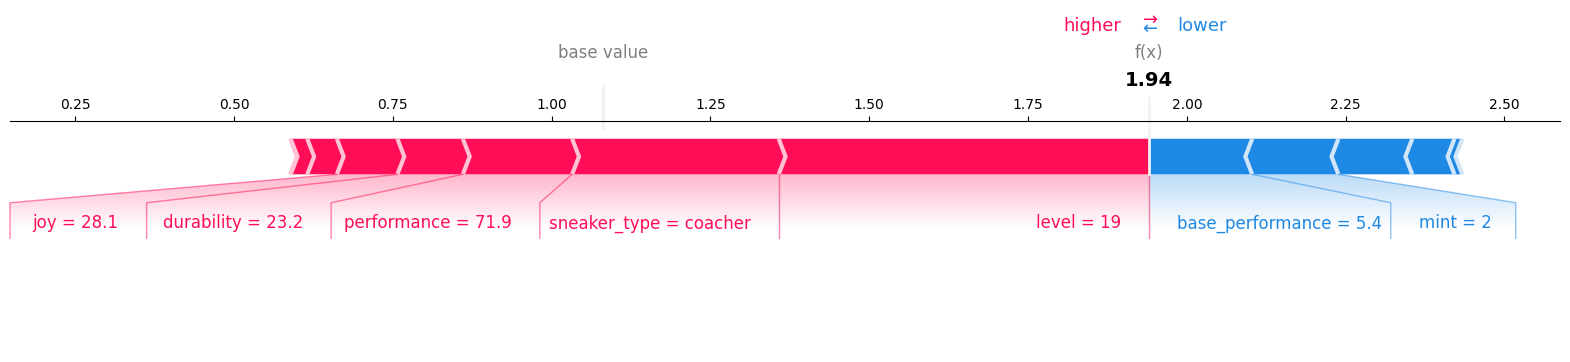

In [85]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


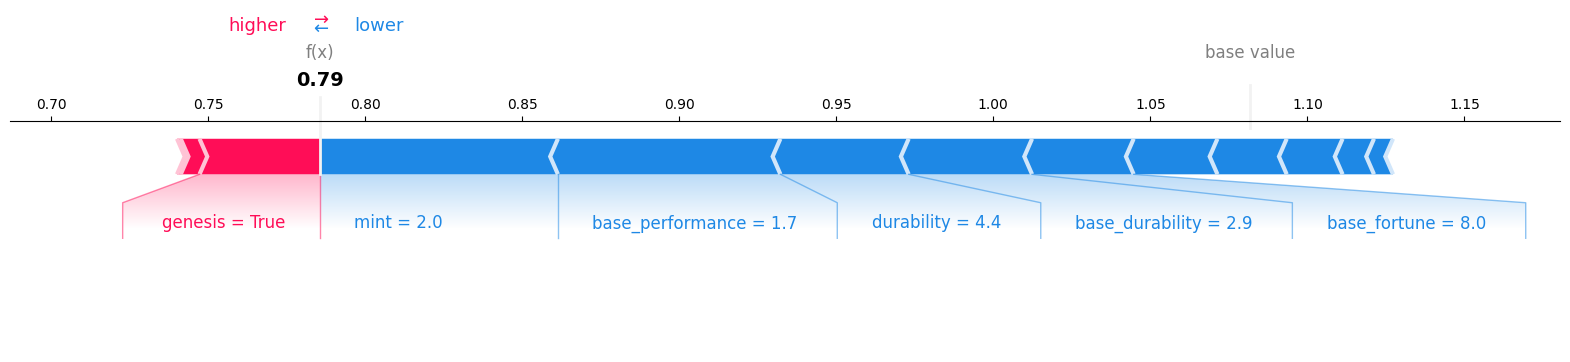

In [86]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [87]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [88]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


In [89]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [90]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664290663,43192,58044,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0xf768a9dab4accc3bdf53174618353b52d242fcf6,0.72,box,common,NaN,...,514.0,8535.0,751,0,352,3338,6358,11728,91.0,1.219512
1,1664284701,43064,61172,buy,0xbdaf85d4d33ff2a656ac67d3a274597f0f5ef6ff,0x39c1e2b5357940e1b3895433caafb68faacc1de3,0.68,box,common,NaN,...,581.0,8528.0,753,0,369,3425,6349,11719,91.0,1.275000
2,1664277449,42969,58206,buy,0x840c35b2a21934727d98cedc5355f1c294b8abe2,0x3df43b2ba58581a54e28df689e36016dbd36b324,0.70,box,common,NaN,...,590.0,8529.0,758,0,389,3439,6369,11723,95.0,1.375000
3,1664271939,42005,60911,buy,0xfc2eb423826124d624db5f7d1a43f8f826750efe,0x89d1217812a2785584291568fe4db6057a156db6,0.94,box,common,NaN,...,585.0,8542.0,761,0,408,3442,6375,11725,96.0,1.400000
4,1664268091,42723,60908,buy,0x1c13f7d354890042de7c4419208dd0f69b38d68e,0xaf8f9e9d80059a7288fb3912c7df478e8c63a48f,0.79,box,common,NaN,...,581.0,8550.0,759,0,419,3464,6374,11719,96.0,1.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,905,0,397,1702,2056,2549,NaN,NaN
1010,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,904,0,388,1664,2002,2492,NaN,NaN
1011,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,903,0,253,1505,1844,2328,NaN,NaN
1012,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,904,0,249,1502,1840,2324,NaN,NaN


In [91]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [92]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [93]:
len(data)

1014

In [94]:
len(data[data.date >= START_DATE])

648

In [95]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [96]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
643,1.662737e+09,651.0,4.0,0.0,NaN,1800.0,300.0,200.0,0.524191
644,1.663838e+09,47202.0,1.0,0.0,NaN,1800.0,300.0,200.0,0.521645
645,1.657800e+09,818.0,18.0,8.0,NaN,1800.0,300.0,200.0,0.522518
646,1.661360e+09,4477.0,6.0,1.0,NaN,1800.0,300.0,200.0,0.522336


In [97]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
643,1664268091,42723,60908,buy,False,ranger,sprinter,2022-09-27 08:41:31
644,1664271939,42005,60911,buy,False,ranger,coacher,2022-09-27 09:45:39
645,1664277449,42969,58206,buy,False,sprinter,sprinter,2022-09-27 11:17:29
646,1664284701,43064,61172,buy,False,sprinter,sprinter,2022-09-27 13:18:21


In [98]:
data.genesis.value_counts()

False    607
True      41
Name: genesis, dtype: int64

In [99]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [100]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [101]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [102]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,1664268091,42723,60908,buy,0x1c13f7d354890042de7c4419208dd0f69b38d68e,0xaf8f9e9d80059a7288fb3912c7df478e8c63a48f,0.79,box,common,NaN,...,1,0,0,0,0,0,0,0,0,0
644,1664271939,42005,60911,buy,0xfc2eb423826124d624db5f7d1a43f8f826750efe,0x89d1217812a2785584291568fe4db6057a156db6,0.94,box,common,NaN,...,0,0,1,0,0,0,0,0,0,0
645,1664277449,42969,58206,buy,0x840c35b2a21934727d98cedc5355f1c294b8abe2,0x3df43b2ba58581a54e28df689e36016dbd36b324,0.70,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
646,1664284701,43064,61172,buy,0xbdaf85d4d33ff2a656ac67d3a274597f0f5ef6ff,0x39c1e2b5357940e1b3895433caafb68faacc1de3,0.68,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0


In [103]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [104]:
data['ranger_hiker'].sum()

63

## FE

In [105]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [106]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [107]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [108]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.32it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.34it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:02,  1.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:03,  1.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:04,  1.36it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:05,  1.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:05,  1.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:06,  1.34it/s]iteritems is deprec

In [109]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.752,0.2718
MAE,0.094,0.0714
MSE,0.400,0.7639
RMSE,0.380,0.5150
MAPE,0.047,0.0088


In [110]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.752,0.2718
MAE,0.094,0.0714
MSE,0.400,0.7639
RMSE,0.380,0.5150
MAPE,0.047,0.0088


In [111]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.444, 'MAE': 0.094, 'MSE': 0.402, 'RMSE': 0.634, 'MAPE': 0.047}

iteritems is deprecated and will be removed in a future version. Use .items instead.


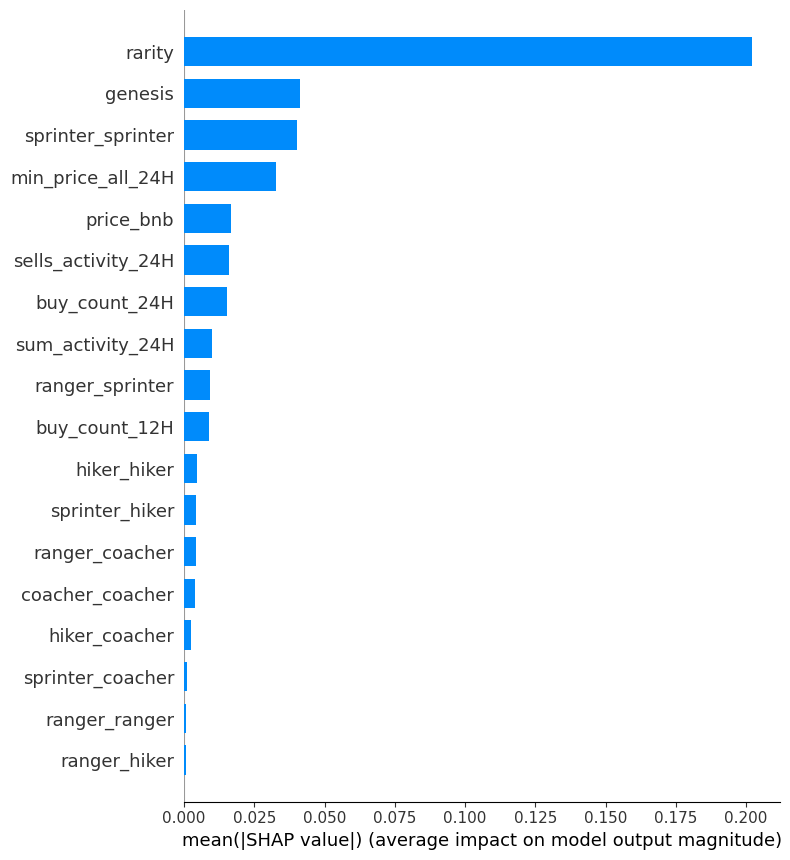

In [112]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [113]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.03823
0:	learn: 0.8354804	total: 1.48ms	remaining: 1.48s
1:	learn: 0.8228990	total: 2.6ms	remaining: 1.3s
2:	learn: 0.8089076	total: 3.66ms	remaining: 1.22s
3:	learn: 0.7952539	total: 4.8ms	remaining: 1.19s
4:	learn: 0.7827602	total: 5.93ms	remaining: 1.18s
5:	learn: 0.7685858	total: 7ms	remaining: 1.16s
6:	learn: 0.7553194	total: 7.68ms	remaining: 1.09s
7:	learn: 0.7433733	total: 8.42ms	remaining: 1.04s
8:	learn: 0.7313944	total: 9.14ms	remaining: 1.01s
9:	learn: 0.7195275	total: 9.84ms	remaining: 975ms
10:	learn: 0.7077966	total: 10.5ms	remaining: 944ms
11:	learn: 0.6967407	total: 11.2ms	remaining: 922ms
12:	learn: 0.6857931	total: 11.9ms	remaining: 903ms
13:	learn: 0.6743891	total: 12.5ms	remaining: 882ms
14:	learn: 0.6642958	total: 13.2ms	remaining: 866ms
15:	learn: 0.6541707	total: 13.8ms	remaining: 852ms
16:	learn: 0.6431485	total: 14.5ms	remaining: 836ms
17:	learn: 0.6328878	total: 15.1ms	remaining: 825ms
18:	learn: 0.6227538	total: 15.8ms	remaining: 815ms

### Test

In [114]:
i = 250

In [115]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2.0,
 'wallet_from_all_count': 9.0,
 'token_all_activity_3H': 0.0,
 'token_sell_activity_6H': 0.0,
 'buy_count_12H': 16.0,
 'buy_count_24H': 25,
 'buy_count_48H': 55.0,
 'sell_count_12H': 18.0,
 'sell_count_24H': 40,
 'sell_count_48H': 96.0,
 'cancel_count_12H': 9.0,
 'cancel_count_24H':

In [116]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H              16.0
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count       2.0
wallet_from_all_count       9.0
dtype: object

In [117]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.024

In [118]:
data.iloc[i]['price']

1.0

In [119]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.447

In [120]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.923

# Box Base Model

In [121]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [122]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [123]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             648 non-null    object
 1   genesis            648 non-null    bool  
 2   ranger_sprinter    648 non-null    int64 
 3   ranger_hiker       648 non-null    int64 
 4   ranger_coacher     648 non-null    int64 
 5   sprinter_hiker     648 non-null    int64 
 6   sprinter_coacher   648 non-null    int64 
 7   hiker_coacher      648 non-null    int64 
 8   ranger_ranger      648 non-null    int64 
 9   sprinter_sprinter  648 non-null    int64 
 10  hiker_hiker        648 non-null    int64 
 11  coacher_coacher    648 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 56.4+ KB


In [125]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.03it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.01it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.04it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  2.04it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:03,  2.06it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  2.05it/s]iteritems is deprec

In [126]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.720,0.2996
MAE,0.115,0.0721
MSE,0.385,0.7228
RMSE,0.386,0.4940
MAPE,0.067,0.0116


In [127]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.720,0.2996
MAE,0.115,0.0721
MSE,0.385,0.7228
RMSE,0.386,0.4940
MAPE,0.067,0.0116


In [128]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.466, 'MAE': 0.115, 'MSE': 0.386, 'RMSE': 0.621, 'MAPE': 0.067}

iteritems is deprecated and will be removed in a future version. Use .items instead.


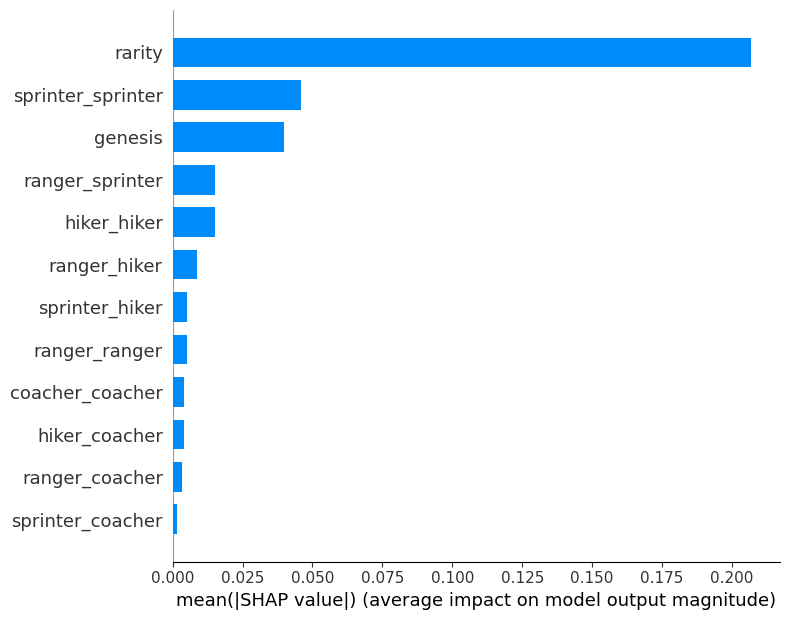

In [129]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [130]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.03823
0:	learn: 0.8343064	total: 710us	remaining: 709ms
1:	learn: 0.8197184	total: 1.21ms	remaining: 606ms
2:	learn: 0.8058767	total: 1.49ms	remaining: 495ms
3:	learn: 0.7924631	total: 2.18ms	remaining: 543ms
4:	learn: 0.7796530	total: 2.65ms	remaining: 527ms
5:	learn: 0.7674318	total: 3.05ms	remaining: 505ms
6:	learn: 0.7562000	total: 3.28ms	remaining: 466ms
7:	learn: 0.7463352	total: 4.18ms	remaining: 518ms
8:	learn: 0.7361456	total: 4.44ms	remaining: 489ms
9:	learn: 0.7273282	total: 4.83ms	remaining: 478ms
10:	learn: 0.7187758	total: 5.25ms	remaining: 472ms
11:	learn: 0.7097265	total: 5.61ms	remaining: 462ms
12:	learn: 0.7011834	total: 5.92ms	remaining: 450ms
13:	learn: 0.6933254	total: 6.62ms	remaining: 466ms
14:	learn: 0.6825835	total: 7.22ms	remaining: 474ms
15:	learn: 0.6730823	total: 7.86ms	remaining: 483ms
16:	learn: 0.6629678	total: 8.44ms	remaining: 488ms
17:	learn: 0.6528296	total: 9.03ms	remaining: 493ms
18:	learn: 0.6429014	total: 9.64ms	remaining: 

## Test

In [131]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.354

In [132]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [133]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [134]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [135]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.045

In [ ]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

In [ ]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.307

In [ ]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.458

In [ ]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.114

In [ ]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.08

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [ ]:
# import ast
# import json

In [ ]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [ ]:
# print(json.dumps(json_data))

In [ ]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [ ]:
#output = json.loads(r.text)

In [ ]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам